In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

### ***Data loading***

In [2]:
df = pd.read_csv('../csv/CICIDS2017_improved-preprocessed.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df.shape

(1715326, 49)

### ***Data splitting***

In [3]:
df_benign = df[df['Label'] == 0]
df_anomalous = df[df['Label'] == 1]

print(f'Number of benign samples: {df_benign.shape[0]}')
print(f'Number of anomalous samples: {df_anomalous.shape[0]}')

Number of benign samples: 1432918
Number of anomalous samples: 282408


In [4]:
df_anomalous_train, df_anomalous_test = train_test_split(df_anomalous, test_size=0.25, random_state=42)
df_anomalous_train, df_anomalous_val = train_test_split(df_anomalous_train, test_size=0.15, random_state=42)

df_benign_train, df_benign_test = train_test_split(df_benign, test_size=0.10, random_state=42)
df_benign_train, df_benign_val = train_test_split(df_benign_train, test_size=0.10, random_state=42)

df_benign_train = df_benign_train.sample(frac=0.30)

print(f'Training: {df_benign_train.shape[0]} - {df_anomalous_train.shape[0]}')
print(f'Test: {df_benign_test.shape[0]} - {df_anomalous_test.shape[0]}')
print(f'Validation: {df_benign_val.shape[0]} - {df_anomalous_val.shape[0]}')

Training: 348199 - 180035
Test: 143292 - 70602
Validation: 128963 - 31771


In [5]:
X_train = pd.concat([df_benign_train, df_anomalous_train]).sample(frac=1)
X_test = pd.concat([df_benign_test, df_anomalous_test]).sample(frac=1)
X_val = pd.concat([df_benign_val, df_anomalous_val]).sample(frac=1)

y_train = X_train.pop('Label').astype(bool)
y_val = X_val.pop('Label').astype(bool)

print('Training dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)
print('Validation dataset shape: ', X_val.shape)

Training dataset shape:  (528234, 48)
Test dataset shape:  (213894, 49)
Validation dataset shape:  (160734, 48)


### ***Data standardization***

In [6]:
std_scaler = StandardScaler() 

#fit scaler on training dataset 
std_scaler.fit(X_train)

#transform data with fitted scaler
X_train_transformed = std_scaler.transform(X_train)
X_val_transformed = std_scaler.transform(X_val)

**Save std_scaler for future purposes**

In [ ]:
joblib.dump(std_scaler, 'std_scaler_dnn.bin')

### ***Training***

In [7]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='DNN_best_weights_99_97.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

In [8]:
input_dim = X_train_transformed.shape[1]

dnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim, )),
    tf.keras.layers.Dense(input_dim, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
    tf.keras.layers.Dense(2, activation='softmax') 
])

dnn.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                2352      
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 2)                 98        
                                                                 
 dense_3 (Dense)             (None, 2)                 6         
                                                                 
Total params: 4808 (18.78 KB)
Trainable params: 4808 (18.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
EPOCHS = 10
BATCH_SIZE = 1024

history = dnn.fit(
    X_train_transformed, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, save_model],
    validation_data=(X_val_transformed, y_val)
)

Epoch 1/10
516/516 [==============================] - 1s 2ms/step - loss: 0.3837 - accuracy: 0.9671 - val_loss: 0.2248 - val_accuracy: 0.9910
Epoch 2/10
107/516 [=====>........................] - ETA: 0s - loss: 0.2395 - accuracy: 0.9854

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


516/516 [==============================] - 1s 2ms/step - loss: 0.1971 - accuracy: 0.9863 - val_loss: 0.1333 - val_accuracy: 0.9920
Epoch 3/10
516/516 [==============================] - 1s 2ms/step - loss: 0.1318 - accuracy: 0.9868 - val_loss: 0.0951 - val_accuracy: 0.9920
Epoch 4/10
516/516 [==============================] - 1s 2ms/step - loss: 0.1020 - accuracy: 0.9870 - val_loss: 0.0747 - val_accuracy: 0.9923
Epoch 5/10
516/516 [==============================] - 1s 2ms/step - loss: 0.0868 - accuracy: 0.9869 - val_loss: 0.0637 - val_accuracy: 0.9924
Epoch 6/10
516/516 [==============================] - 1s 2ms/step - loss: 0.0779 - accuracy: 0.9871 - val_loss: 0.0574 - val_accuracy: 0.9924
Epoch 7/10
516/516 [==============================] - 1s 2ms/step - loss: 0.0728 - accuracy: 0.9872 - val_loss: 0.0533 - val_accuracy: 0.9924
Epoch 8/10
516/516 [==============================] - 1s 2ms/step - loss: 0.0698 - accuracy: 0.9872 - val_loss: 0.0511 - val_accuracy: 0.9923
Epoch 9/10
516/51

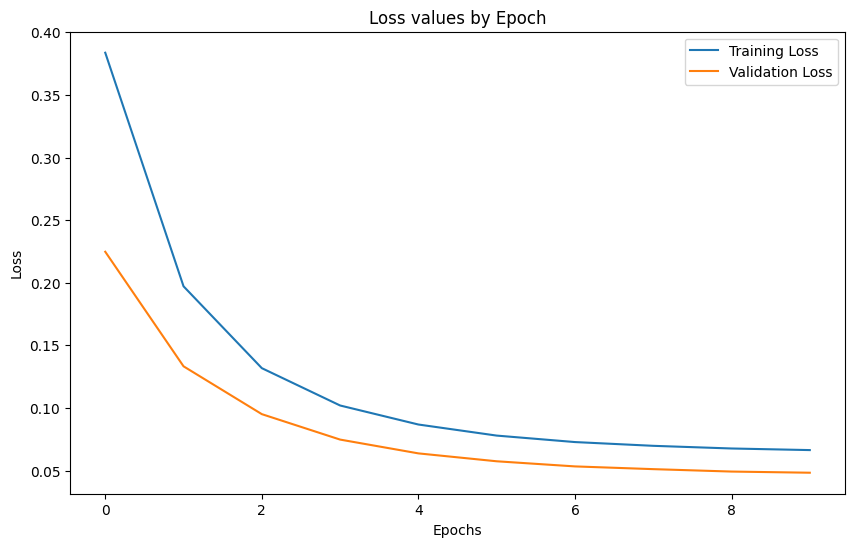

In [10]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [11]:
y_test = X_test.pop('Label')
X_test_transformed = std_scaler.transform(X_test)

In [13]:
preds = dnn.predict(X_test_transformed, verbose=False)

preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0

preds = preds[:, 1]

print("DNN classification report on test dataset\n\n")
print(classification_report(y_test.astype(bool), preds.astype(bool)))

DNN classification report on test dataset


              precision    recall  f1-score   support

       False       0.98      1.00      0.99    143292
        True       1.00      0.96      0.98     70602

    accuracy                           0.99    213894
   macro avg       0.99      0.98      0.99    213894
weighted avg       0.99      0.99      0.99    213894

